# 05 – Analysis: Staffing Capacity, Workforce Context, and Hospital Quality

## Overview
This notebook conducts the primary analysis by evaluating whether hospital staffing capacity is
associated with hospital quality outcomes. Staffing capacity is derived from CMS Hospital Provider
Cost Report staffing intensity metrics, and quality outcomes are captured via CMS Hospital Overall
Ratings and related outcome group summaries.

Regional nursing workforce measures from BLS (MSA where available, with state-level fallback) are
included as contextual indicators of labor market conditions. All results are interpreted as
associative rather than causal.

The unit of analysis is the hospital.

Star ratings are converted to numeric values to allow quantitative explained and regression analysis. Observations with missing staffing or rating data are excluded to ensure consistent comparisons.

## 1. Load and Prepare Final Merged Dataset

Overview

This section loads the fully merged analysis dataset, which combines: • CMS Hospital Cost Report data (staffing intensity) • CMS Hospital Star Ratings (quality outcomes) • BLS Nursing Workforce data (labor market context)

The unit of analysis is the hospital.

Star ratings are converted to numeric values to allow quantitative explained and regression analysis. Observations with missing staffing or rating data are excluded to ensure consistent comparisons.

In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)

# Robust path handling
ROOT = Path.cwd().resolve()

if ROOT.name == "notebooks" and ROOT.parent.name == "src":
    ROOT = ROOT.parent.parent
elif ROOT.name == "src":
    ROOT = ROOT.parent

ANALYSIS_PATH = ROOT / "src" / "data" / "interim" / "analysis_dataset.csv"

print("Reading:", ANALYSIS_PATH)
assert ANALYSIS_PATH.exists(), "File not found."

df = pd.read_csv(ANALYSIS_PATH)

print(df.shape)
print(df.columns.tolist())
df.head()

Reading: /voc/work/src/data/interim/analysis_dataset.csv
(5204, 44)
['Provider CCN', 'Hospital Name', 'State Code', 'Medicare CBSA Number', 'cbsa', 'Fiscal Year Begin Date', 'Fiscal Year End Date', 'FTE - Employees on Payroll', 'Total Days (V + XVIII + XIX + Unknown)', 'Number of Beds', 'fte_per_1000_days', 'fte_per_bed', 'cbsa_str', 'Facility ID', 'Facility Name', 'State', 'ZIP Code', 'Hospital Type', 'Hospital Ownership', 'Emergency Services', 'Meets criteria for birthing friendly designation', 'Hospital overall rating', 'Hospital overall rating footnote', 'MORT Group Measure Count', 'Safety Group Measure Count', 'READM Group Measure Count', 'Pt Exp Group Measure Count', 'TE Group Measure Count', 'AREA', 'AREA_TITLE_msa', 'PRIM_STATE_msa', 'TOT_EMP_msa', 'JOBS_1000_msa', 'A_MEAN_msa', 'H_MEAN_msa', 'PRIM_STATE', 'TOT_EMP_state', 'JOBS_1000_state', 'A_MEAN_state', 'H_MEAN_state', 'rn_emp_best', 'rn_jobs_per_1000_best', 'rn_wage_best', 'rn_hourly_best']


,Provider CCN,Hospital Name,State Code,Medicare CBSA Number,cbsa,Fiscal Year Begin Date,Fiscal Year End Date,FTE - Employees on Payroll,Total Days (V + XVIII + XIX + Unknown),Number of Beds,fte_per_1000_days,fte_per_bed,cbsa_str,Facility ID,Facility Name,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for birthing friendly designation,Hospital overall rating,Hospital overall rating footnote,MORT Group Measure Count,Safety Group Measure Count,READM Group Measure Count,Pt Exp Group Measure Count,TE Group Measure Count,AREA,AREA_TITLE_msa,PRIM_STATE_msa,TOT_EMP_msa,JOBS_1000_msa,A_MEAN_msa,H_MEAN_msa,PRIM_STATE,TOT_EMP_state,JOBS_1000_state,A_MEAN_state,H_MEAN_state,rn_emp_best,rn_jobs_per_1000_best,rn_wage_best,rn_hourly_best
0,144042,LAKE BEHAVIORAL HOSPITAL,IL,29404.0,29404.0,2022-10-01,2022-12-31,227.95,10311.0,161.0,22.107458,1.415839,29404.0,144042,LAKE BEHAVIORAL HOSPITAL,IL,60085,Psychiatric,Proprietary,No,NaN,NaN,19,Not Available,Not Available,Not Available,Not Available,Not Available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IL,139900.0,23.066,91130.0,43.81,139900.0,23.066,91130.0,43.81
1,454155,OCEANS BEHAVIORAL HOSPITAL CORPUS CH,TX,18580.0,18580.0,2022-11-17,2022-12-31,68.01,1041.0,42.0,65.331412,1.619286,18580.0,454155,OCEANS BEHAVIORAL HOSPITAL OF CORPUS CHRISTI,TX,78404,Psychiatric,Proprietary,No,NaN,NaN,19,Not Available,Not Available,Not Available,Not Available,Not Available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX,261050.0,18.853,91690.0,44.08,261050.0,18.853,91690.0,44.08
2,144043,MONTROSE BEHAVIORAL HEALTH HOSPITAL,IL,NaN,NaN,2022-10-03,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,144043,MONTROSE BEHAVIORAL HEALTH HOSPITAL,IL,60640,Psychiatric,Proprietary,Yes,NaN,NaN,19,Not Available,Not Available,Not Available,Not Available,Not Available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IL,139900.0,23.066,91130.0,43.81,139900.0,23.066,91130.0,43.81
3,30153,EAST VALLEY ER AND HOSPITAL,AZ,38060.0,38060.0,2022-10-14,2023-01-31,59.99,151.0,14.0,397.284768,4.285000,38060.0,30153,EAST VALLEY ER & HOSPITAL,AZ,85295,Acute Care Hospitals,Proprietary,Yes,NaN,NaN,16,7,8,11,8,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AZ,64430.0,20.155,95230.0,45.79,64430.0,20.155,95230.0,45.79
4,230110,COREWELL HEALTH LUDINGTON HOSPITAL,MI,99923.0,99923.0,2023-01-01,2023-06-30,309.08,3648.0,39.0,84.725877,7.925128,99923.0,230110,COREWELL HEALTH LUDINGTON HOSPITAL,MI,49431,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Y,4.0,NaN,7,8,11,8,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MI,104210.0,23.735,90580.0,43.55,104210.0,23.735,90580.0,43.55


## 2. Initial Hospital-Level Relationship

Objective: Examine whether staffing intensity is associated with overall hospital star ratings.

We visualize the relationship between:

    FTE per 1,000 patient days (staffing intensity)

    Overall star rating (1–5)

Because star ratings are discrete, we add a small vertical jitter to reduce overplotting.

We trim the top 1% of staffing intensity values to reduce the influence of extreme facilities and improve interpretability.

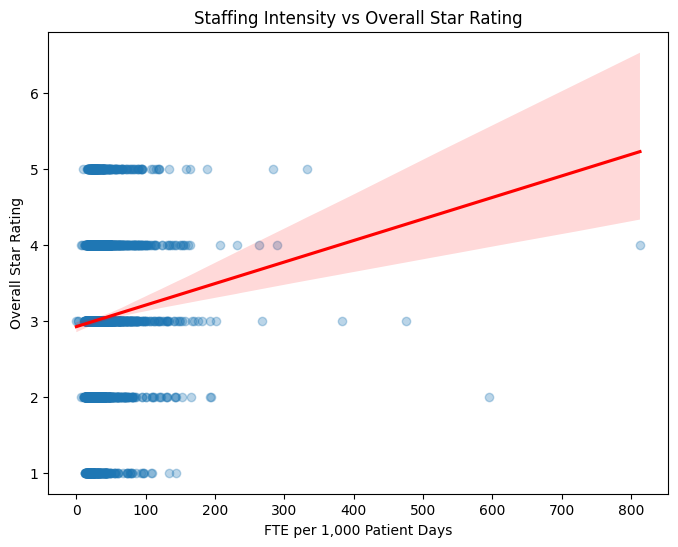

In [10]:
df["Hospital overall rating"] = pd.to_numeric(
df["Hospital overall rating"], errors="coerce")
df_analysis = df.dropna(subset=["Hospital overall rating", "fte_per_1000_days"])
staff_var = "fte_per_1000_days"
rating_var = "Hospital overall rating"
bls_var = "rn_jobs_per_1000_best"
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.regplot(
    data=df_analysis,
    x=staff_var,
    y=rating_var,
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"}
)

plt.title("Staffing Intensity vs Overall Star Rating")
plt.xlabel("FTE per 1,000 Patient Days")
plt.ylabel("Overall Star Rating")
plt.show()

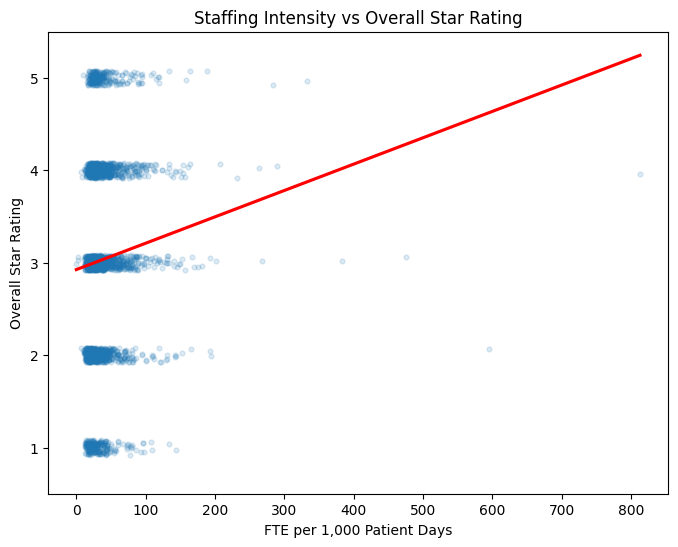

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Add a tiny vertical jitter so stacked points separate visually
y_jitter = df_analysis[rating_var] + np.random.uniform(-0.08, 0.08, size=len(df_analysis))

sns.regplot(
    data=df_analysis,
    x=staff_var,
    y=y_jitter,
    scatter_kws={"alpha": 0.15, "s": 12},
    line_kws={"color": "red"},
    ci=None  # remove the wide confidence band that looks like a wedge
)

plt.title("Staffing Intensity vs Overall Star Rating")
plt.xlabel("FTE per 1,000 Patient Days")
plt.ylabel("Overall Star Rating")

# Force the chart to show only 1–5 stars (no 0.5 or 6)
plt.yticks([1, 2, 3, 4, 5])
plt.ylim(0.5, 5.5)

plt.show()

In [12]:
upper_cut = df_analysis[staff_var].quantile(0.99)

df_trim = df_analysis[
    df_analysis[staff_var] <= upper_cut
].copy()

print("Original rows:", len(df_analysis))
print("Trimmed rows:", len(df_trim))
print("Dropped:", len(df_analysis) - len(df_trim))

Original rows: 2763
Trimmed rows: 2735
Dropped: 28


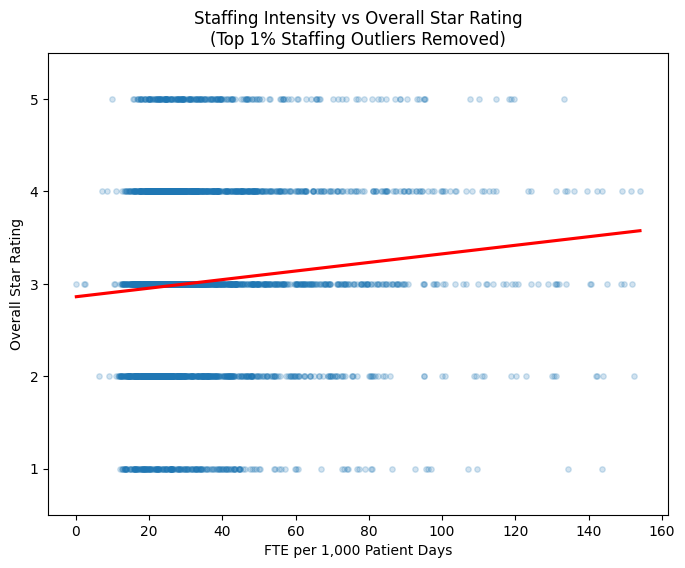

In [13]:
plt.figure(figsize=(8,6))

sns.regplot(
    data=df_trim,
    x=staff_var,
    y=rating_var,
    scatter_kws={"alpha":0.2, "s":15},
    line_kws={"color":"red"},
    ci=None
)

plt.title("Staffing Intensity vs Overall Star Rating\n(Top 1% Staffing Outliers Removed)")
plt.xlabel("FTE per 1,000 Patient Days")
plt.ylabel("Overall Star Rating")

plt.yticks([1, 2, 3, 4, 5])
plt.ylim(0.5, 5.5)

plt.show()

## 3. Correlation and Group Means
Correlation Analysis

A Pearson correlation coefficient is calculated between staffing intensity and star rating.

The resulting correlation (~0.10) indicates a weak but positive association.

Group Means

Average staffing levels are calculated by star rating category. Standard errors are plotted to illustrate variability.

This comparison shows: • 1-star hospitals: lower mean staffing • 5-star hospitals: higher mean staffing • Approximately a 20% staffing difference between lowest and highest rated hospitals

This provides intuitive evidence that staffing levels differ meaningfully across quality tiers.

In [15]:
df_trim[[staff_var, rating_var]].corr()

,fte_per_1000_days,Hospital overall rating
fte_per_1000_days,1.000000,0.099749
Hospital overall rating,0.099749,1.000000


In [16]:
df_trim.groupby(rating_var)[staff_var].mean()

Hospital overall rating
1.0    33.790463
2.0    33.545641
3.0    38.271623
4.0    39.255784
5.0    40.388867
Name: fte_per_1000_days, dtype: float64

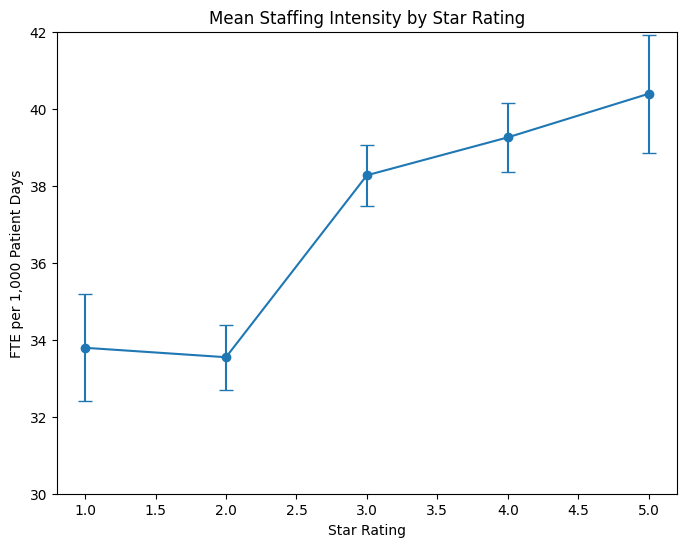

In [17]:
import numpy as np

group_stats = (
    df_trim
    .groupby(rating_var)[staff_var]
    .agg(["mean", "std", "count"])
    .reset_index()
)

group_stats["se"] = group_stats["std"] / np.sqrt(group_stats["count"])

plt.figure(figsize=(8,6))

plt.errorbar(
    group_stats[rating_var],
    group_stats["mean"],
    yerr=group_stats["se"],
    fmt='o-',
    capsize=5
)

plt.title("Mean Staffing Intensity by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("FTE per 1,000 Patient Days")
plt.ylim(30, 42)
plt.show()

In [18]:
mean_1 = df_trim[df_trim[rating_var] == 1][staff_var].mean()
mean_5 = df_trim[df_trim[rating_var] == 5][staff_var].mean()

pct_diff = (mean_5 - mean_1) / mean_1 * 100

mean_1, mean_5, pct_diff

(np.float64(33.790462568910144),
 np.float64(40.388866912946895),
 np.float64(19.5274164435612))

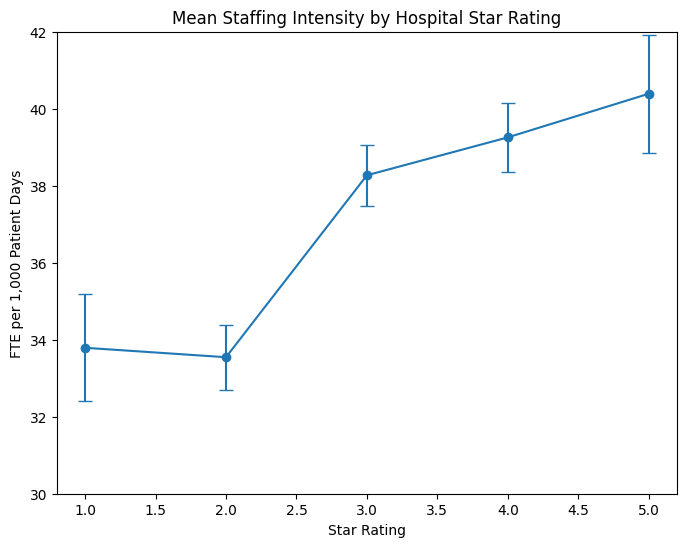

In [19]:
import numpy as np
import matplotlib.pyplot as plt

group_stats = (
    df_trim
    .groupby(rating_var)[staff_var]
    .agg(["mean", "std", "count"])
    .reset_index()
)

group_stats["se"] = group_stats["std"] / np.sqrt(group_stats["count"])

plt.figure(figsize=(8,6))

plt.errorbar(
    group_stats[rating_var],
    group_stats["mean"],
    yerr=group_stats["se"],
    fmt='o-',
    capsize=5
)

plt.title("Mean Staffing Intensity by Hospital Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("FTE per 1,000 Patient Days")
plt.ylim(30, 42)

plt.show()

## 3. Workforce Context: RN Supply and Staffing

Objective
Assess whether hospitals located in areas with higher RN labor supply exhibit higher staffing intensity.

Hospitals are split into: • High RN supply areas (above median) • Low RN supply areas (below median)

A boxplot compares staffing distributions across supply groups.

Interpretation

Hospitals in higher RN supply regions exhibit higher staffing intensity on average. This suggests labor market context may influence staffing capacity.

In [20]:
median_supply = df_trim[bls_var].median()

df_trim["high_supply"] = df_trim[bls_var] > median_supply
df_trim.groupby("high_supply")[staff_var].mean()

high_supply
False    35.852071
True     38.674367
Name: fte_per_1000_days, dtype: float64

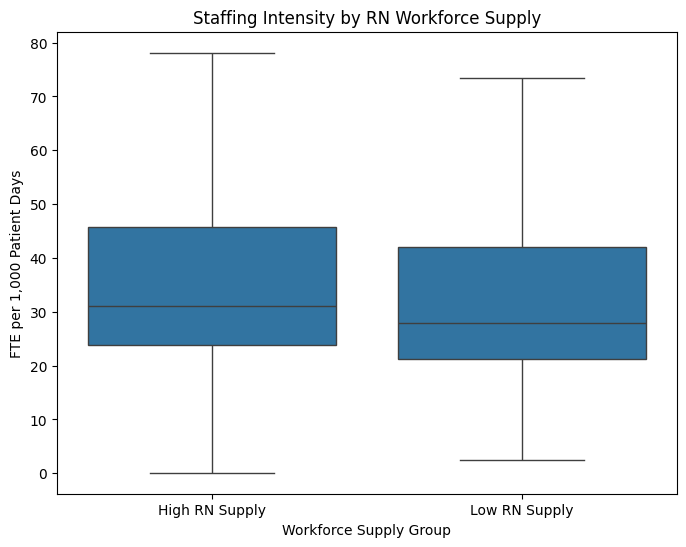

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

median_supply = df_trim[bls_var].median()

df_trim["supply_group"] = np.where(
    df_trim[bls_var] > median_supply,
    "High RN Supply",
    "Low RN Supply"
)
plt.figure(figsize=(8,6))

sns.boxplot(
    data=df_trim,
    x="supply_group",
    y=staff_var,
    showfliers=False
)

plt.title("Staffing Intensity by RN Workforce Supply")
plt.xlabel("Workforce Supply Group")
plt.ylabel("FTE per 1,000 Patient Days")

plt.show()

## 5. State-Level Aggregation
Objective

Reduce hospital-level noise and evaluate structural patterns at the state level.

Hospitals are aggregated by state to compute: • Mean staffing intensity • Mean star rating • Mean RN labor supply • Number of hospitals per state

State-Level Staffing vs Rating

A regression plot at the state level shows a stronger association (~0.30 correlation) between average staffing and average star rating.

Aggregation reduces hospital-level heterogeneity and highlights broader structural differences across states.

Bubble size reflects the number of hospitals in each state.

Interpretation

States with higher average staffing intensity tend to have higher average star ratings, though the relationship remains moderate in magnitude.

In [22]:
state_df = (
    df_trim
    .groupby("State Code")
    .agg(
        mean_staffing=("fte_per_1000_days", "mean"),
        mean_rating=("Hospital overall rating", "mean"),
        mean_rn_supply=("rn_jobs_per_1000_best", "mean"),
        hospital_count=("Provider CCN", "count")
    )
    .reset_index()
)

state_df.head()

,State Code,mean_staffing,mean_rating,mean_rn_supply,hospital_count
0,AK,49.555997,2.857143,21.920,7
1,AL,27.841765,2.469388,25.503,49
2,AR,39.474636,2.552632,21.970,38
3,AZ,27.110550,2.862745,20.155,51
4,CA,29.977415,2.980620,18.093,258


In [23]:
state_df[["mean_staffing", "mean_rating"]].corr()

,mean_staffing,mean_rating
mean_staffing,1.000000,0.296063
mean_rating,0.296063,1.000000


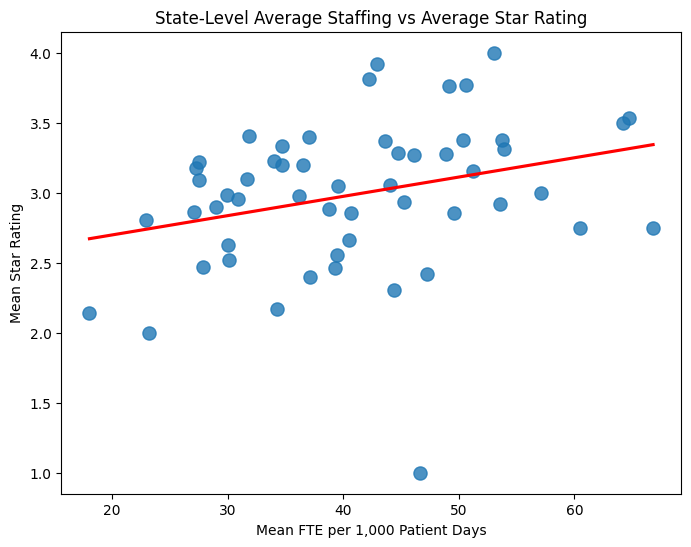

In [24]:
plt.figure(figsize=(8,6))

sns.regplot(
    data=state_df,
    x="mean_staffing",
    y="mean_rating",
    scatter_kws={"s":90},
    line_kws={"color":"red"},
    ci=None
)

plt.title("State-Level Average Staffing vs Average Star Rating")
plt.xlabel("Mean FTE per 1,000 Patient Days")
plt.ylabel("Mean Star Rating")

plt.show()

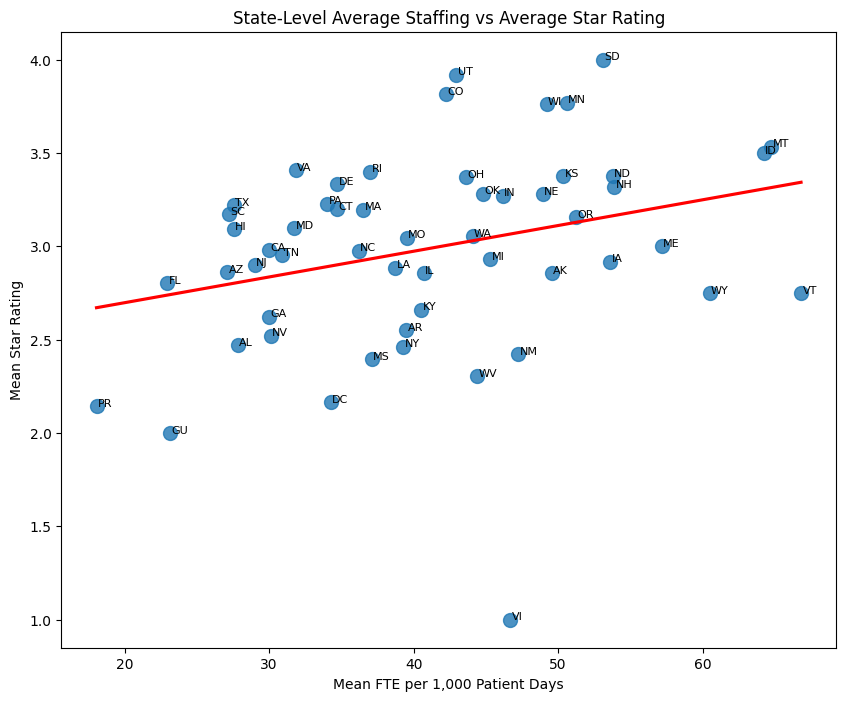

In [25]:
plt.figure(figsize=(10,8))

sns.regplot(
    data=state_df,
    x="mean_staffing",
    y="mean_rating",
    scatter_kws={"s":100},
    line_kws={"color":"red"},
    ci=None
)

for i in range(len(state_df)):
    plt.text(
        state_df["mean_staffing"][i] + 0.1,
        state_df["mean_rating"][i],
        state_df["State Code"][i],
        fontsize=8
    )

plt.title("State-Level Average Staffing vs Average Star Rating")
plt.xlabel("Mean FTE per 1,000 Patient Days")
plt.ylabel("Mean Star Rating")

plt.show()

In [26]:
state_df[["mean_rn_supply", "mean_staffing"]].corr()

,mean_rn_supply,mean_staffing
mean_rn_supply,1.000000,0.157593
mean_staffing,0.157593,1.000000


## 6. Regression Analysis
Model 1: Staffing Only

An OLS regression estimates the association between staffing intensity and star rating.

Findings: • Staffing coefficient is positive and statistically significant. • R² ≈ 0.01, indicating staffing explains approximately 1% of variation in ratings.

This suggests staffing is one contributing factor among many in determining composite hospital ratings.

In [27]:
import statsmodels.api as sm

# Define variables
X = df_trim[["fte_per_1000_days"]]
y = df_trim["Hospital overall rating"]

X = sm.add_constant(X)

model1 = sm.OLS(y, X).fit()
print(model1.summary())

                               OLS Regression Results                              
Dep. Variable:     Hospital overall rating   R-squared:                       0.010
Model:                                 OLS   Adj. R-squared:                  0.010
Method:                      Least Squares   F-statistic:                     27.47
Date:                     Thu, 12 Feb 2026   Prob (F-statistic):           1.72e-07
Time:                             20:39:08   Log-Likelihood:                -4078.5
No. Observations:                     2735   AIC:                             8161.
Df Residuals:                         2733   BIC:                             8173.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [28]:
X2 = df_trim[["fte_per_1000_days", "rn_jobs_per_1000_best"]]
X2 = sm.add_constant(X2)

model2 = sm.OLS(y, X2).fit()
print(model2.summary())

                               OLS Regression Results                              
Dep. Variable:     Hospital overall rating   R-squared:                       0.012
Model:                                 OLS   Adj. R-squared:                  0.012
Method:                      Least Squares   F-statistic:                     17.15
Date:                     Thu, 12 Feb 2026   Prob (F-statistic):           3.95e-08
Time:                             20:39:24   Log-Likelihood:                -4075.1
No. Observations:                     2735   AIC:                             8156.
Df Residuals:                         2732   BIC:                             8174.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

# Model 2: Staffing + RN Supply

Adding RN labor supply as a control: • Staffing remains significant. • RN supply is not statistically significant. • R² increases minimally.

Interpretation: Labor supply appears to influence staffing levels, but does not independently predict star ratings after accounting for staffing intensity.

Standardized Model

Standardizing predictors allows comparison of effect sizes. • Staffing effect size ≈ 0.11 standard deviations • RN supply effect size small and not significant

This confirms staffing has a modest but consistent association with quality outcomes.

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(df_trim[["fte_per_1000_days", "rn_jobs_per_1000_best"]])
X_scaled = sm.add_constant(X_scaled)

model_std = sm.OLS(y, X_scaled).fit()
print(model_std.summary())


                               OLS Regression Results                              
Dep. Variable:     Hospital overall rating   R-squared:                       0.012
Model:                                 OLS   Adj. R-squared:                  0.012
Method:                      Least Squares   F-statistic:                     17.15
Date:                     Thu, 12 Feb 2026   Prob (F-statistic):           3.95e-08
Time:                             20:40:08   Log-Likelihood:                -4075.1
No. Observations:                     2735   AIC:                             8156.
Df Residuals:                         2732   BIC:                             8174.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

## 7. Distribution of Staffing Intensity
A histogram illustrates the distribution of staffing intensity across hospitals.

The distribution shows substantial heterogeneity, reinforcing the importance of trimming extreme outliers for regression stability and visualization clarity.

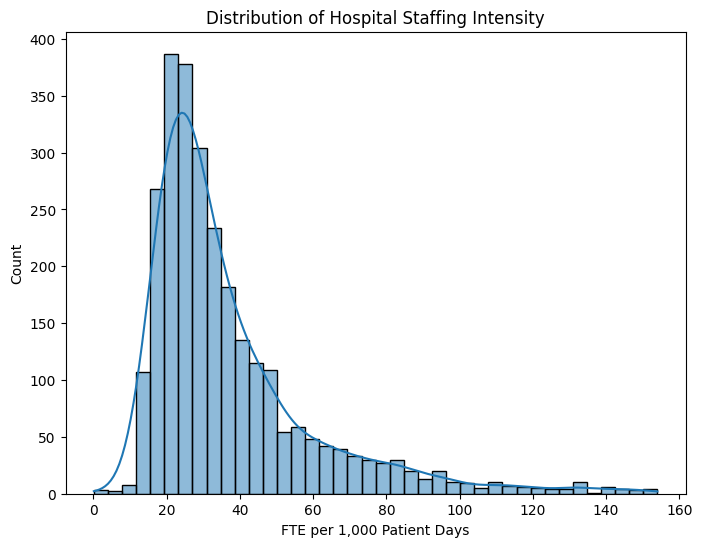

In [30]:
plt.figure(figsize=(8,6))

sns.histplot(
    df_trim["fte_per_1000_days"],
    bins=40,
    kde=True
)

plt.title("Distribution of Hospital Staffing Intensity")
plt.xlabel("FTE per 1,000 Patient Days")
plt.ylabel("Count")

plt.show()

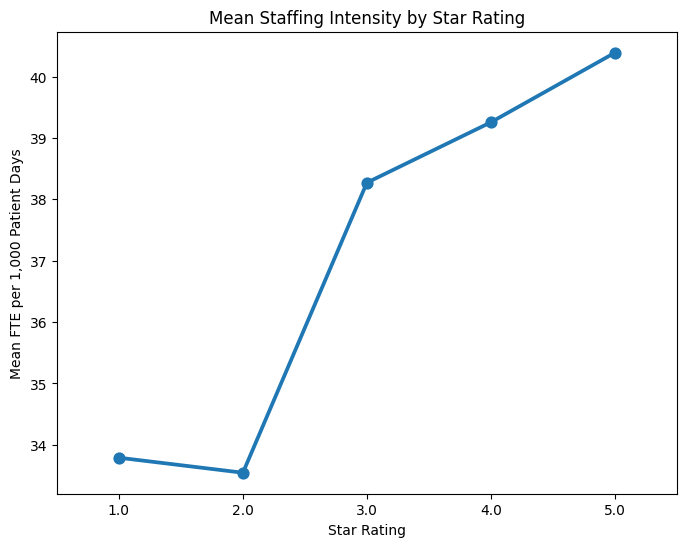

In [31]:
group_stats = (
    df_trim
    .groupby("Hospital overall rating")["fte_per_1000_days"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,6))

sns.pointplot(
    data=group_stats,
    x="Hospital overall rating",
    y="fte_per_1000_days"
)

plt.title("Mean Staffing Intensity by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Mean FTE per 1,000 Patient Days")

plt.show()

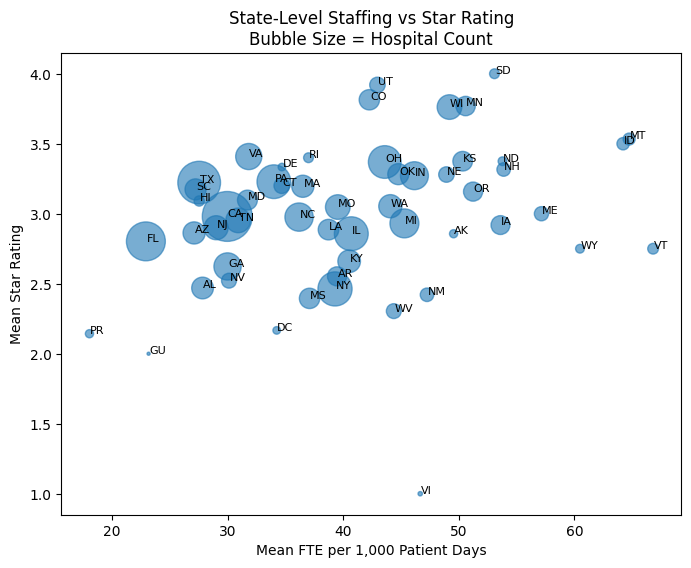

In [32]:
plt.figure(figsize=(8,6))

plt.scatter(
    state_df["mean_staffing"],
    state_df["mean_rating"],
    s=state_df["hospital_count"] * 5,
    alpha=0.6
)

for i in range(len(state_df)):
    plt.text(
        state_df["mean_staffing"][i] + 0.05,
        state_df["mean_rating"][i],
        state_df["State Code"][i],
        fontsize=8
    )

plt.title("State-Level Staffing vs Star Rating\nBubble Size = Hospital Count")
plt.xlabel("Mean FTE per 1,000 Patient Days")
plt.ylabel("Mean Star Rating")

plt.show()

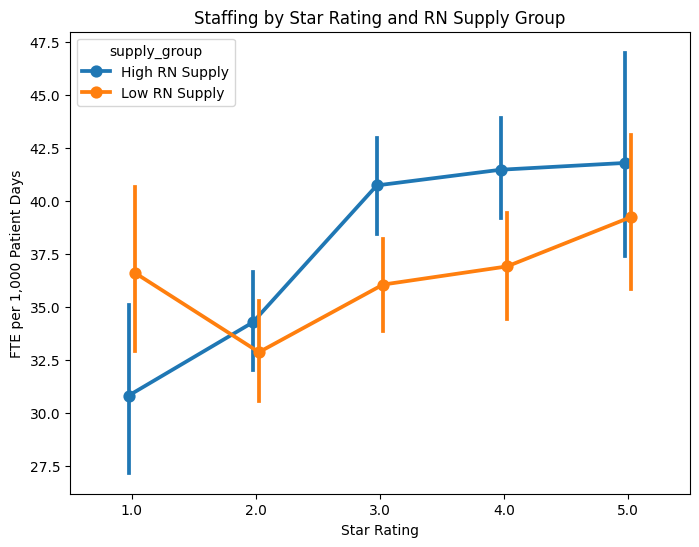

In [33]:
plt.figure(figsize=(8,6))

sns.pointplot(
    data=df_trim,
    x="Hospital overall rating",
    y="fte_per_1000_days",
    hue="supply_group",
    dodge=True
)

plt.title("Staffing by Star Rating and RN Supply Group")
plt.xlabel("Star Rating")
plt.ylabel("FTE per 1,000 Patient Days")

plt.show()

## 9. Correlation Matrix
A heatmap summarizes pairwise relationships between: • Staffing intensity • Star rating • RN labor supply

This provides a concise visual summary of structural relationships tested in regression.

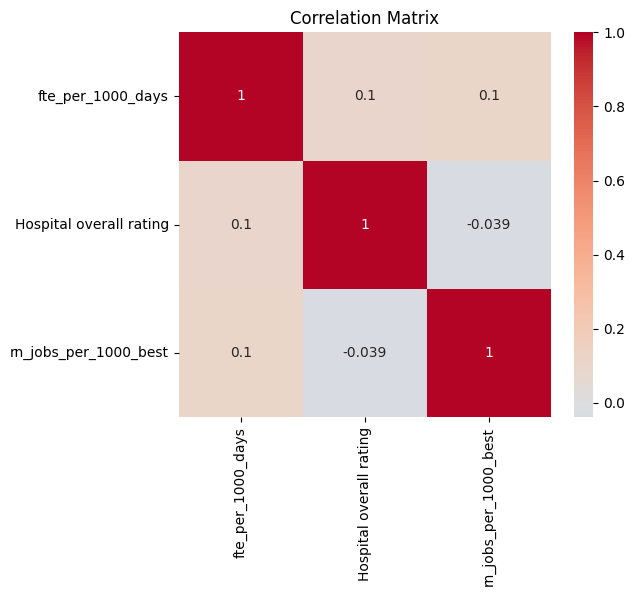

In [34]:
corr_matrix = df_trim[
    ["fte_per_1000_days",
     "Hospital overall rating",
     "rn_jobs_per_1000_best"]
].corr()

plt.figure(figsize=(6,5))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0
)

plt.title("Correlation Matrix")

plt.show()

## 10. State Rankings
Bar plots rank states by average star rating.

This provides descriptive context and highlights interstate variation in quality performance.

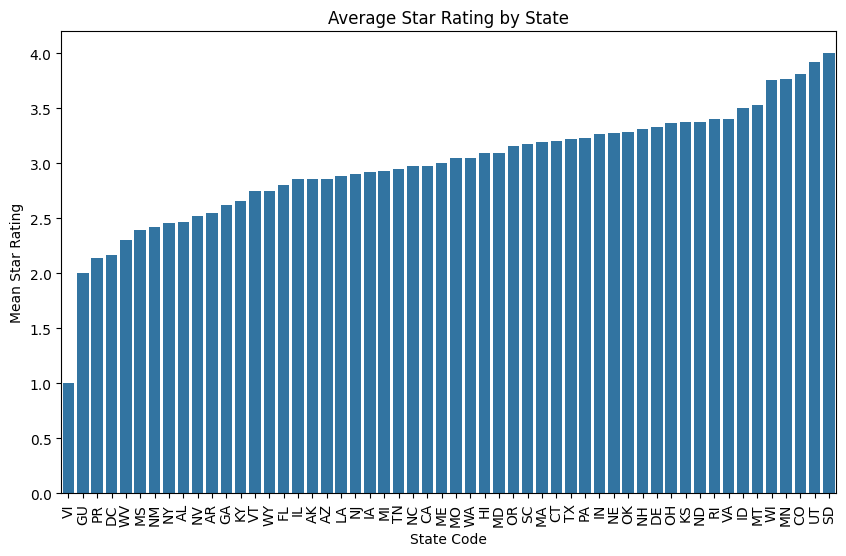

In [35]:
state_sorted = state_df.sort_values("mean_rating")

plt.figure(figsize=(10,6))

sns.barplot(
    data=state_sorted,
    x="State Code",
    y="mean_rating"
)

plt.xticks(rotation=90)
plt.title("Average Star Rating by State")
plt.ylabel("Mean Star Rating")

plt.show()